In [1]:
import sys
sys.path.insert(0, "/notebooks/pipenv")
sys.path.insert(0, "/notebooks/nebula3_vlm")
sys.path.insert(0, "/notebooks/nebula3_database")
sys.path.insert(0, "/notebooks/")
import os
import math
import random
import bisect
import pickle
import time
import copy
import numpy as np


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import subprocess
import re
import tempfile
import itertools
import torch
import spacy
from torch.nn.functional import softmax as torch_softmax
from sumproduct import Variable, Factor, FactorGraph

# import amrlib
# import penman

from typing import List, Tuple
from operator import itemgetter 
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification, BertForNextSentencePrediction
from database.arangodb import DatabaseConnector
from config import NEBULA_CONF
from movie_db import MOVIE_DB


In [3]:
class PIPELINE:
    def __init__(self):
        config = NEBULA_CONF()
        self.db_host = config.get_database_host()
        self.database = config.get_playground_name()
        self.gdb = DatabaseConnector()
        self.db = self.gdb.connect_db(self.database)

pipeline = PIPELINE()
mdb = MOVIE_DB()
from vlm.clip_api import CLIP_API
clip=CLIP_API('vit')
s2_collection_name = 's2_pipeline_after_gpt'
s2_results_orig_collection_name = 's2_pipeline_optim_orig'
s2_results_relaxed_collection_name = 's2_pipeline_optim_relaxed'
s2_compatibility_collection_name = 's2_pipeline_compatibility_scores'
s2_with_compat_collection_name = 's2_pipeline_compatibility_results'
s2_with_compat_collection_name2 = 's2_pipeline_compatibility_results2'


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
device = "cuda:0"
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def create_2chain_graph(factors):
    g = FactorGraph(silent=True)  # init the graph without message printouts
    num_vars = len(factors)+1
    vars = []
    vnames = []
    gvars = []
    for i in range(len(factors)-1):
        assert factors[i].shape[1] == factors[i+1].shape[0]
        vars.append(factors[i].shape[0])
    vars.append(factors[-1].shape[0])
    vars.append(factors[-1].shape[1])
    for i, v_size in enumerate(vars):
        vname = 'x'+str(i+1)
        v = Variable(vname, v_size)
        vnames.append(vname)
        gvars.append(v)

    for i in range(len(gvars)-1):
        fname = 'f{}{}'.format(i+1, i+2)
        # factors are transposed, from x2 to x1, etc'
        fact = Factor(fname, factors[i].transpose())
        g.add(fact)
        g.append(fname, gvars[i+1])
        g.append(fname, gvars[i])

    return g, vnames


def create_3chain_graph(factors):
    g = FactorGraph(silent=True)  # init the graph without message printouts
    num_vars = len(factors)+2
    vars = []
    vnames = []
    gvars = []
    for i in range(len(factors)-2):
        assert factors[i].shape[1] == factors[i+1].shape[0]
        assert factors[i].shape[2] == factors[i+1].shape[1]
        assert factors[i].shape[2] == factors[i+2].shape[0]
        vars.append(factors[i].shape[0])
    vars.append(factors[-2].shape[0])
    vars.append(factors[-2].shape[1])
    vars.append(factors[-2].shape[2])
    vars.append(factors[-1].shape[2])
    for i, n in enumerate(vars):
        vname = 'x'+str(i+1)
        v = Variable(vname, n)
        vnames.append(vname)
        gvars.append(v)
    for i in range(len(gvars)-2):
        fname = 'f{}{}{}'.format(i+1, i+2, i+3)
        fact = Factor(fname, factors[i].transpose(
            2, 1, 0))     # factors are transposed
        g.add(fact)
        g.append(fname, gvars[i+2])
        g.append(fname, gvars[i+1])
        g.append(fname, gvars[i])

    return g, vnames

def compute_marginals(factors, chain_creator):
    g, vnames = chain_creator(factors)
    g.compute_marginals(max_iter=15500, tolerance=1e-8)
    rc = []
    for vname in vnames:
        rc.append(g.nodes[vname].marginal())
    return rc

def compute_2chain_marginals(factors):
    return compute_marginals(factors, create_2chain_graph)


def compute_3chain_marginals(factors):
    return compute_marginals(factors, create_3chain_graph)

# def compute_2chain_marginals_orig(factors):
#     g, vnames = create_2chain_graph(factors)
#     g.compute_marginals(max_iter=15500, tolerance=1e-8)
#     rc = []
#     for vname in vnames:
#         rc.append(g.nodes[vname].marginal())
#     return rc

# Input: A list of list of strings
# Output: A list of list of scores

def story_compatability(scene1, scene2):
    rows_ = []
    for sent_a in scene1:
        cols_ = []
        for sent_b in scene2:
            encoded = tokenizer.encode_plus(sent_a, sent_b, return_tensors='pt').to(device)
            seq_relationship_logits = model(**encoded)[0]
            probs = torch_softmax(seq_relationship_logits, dim=1)
            score = probs[0][0].tolist()
            cols_.append(score)
        rows_.append(cols_)
    return(np.array(rows_))


def score_story(story):
    scenes_scores = []   # factors
    for idx in range(0, len(story) -1):
        scene1 = story[idx]
        scene2 = story[idx + 1]
        scene_matrix = story_compatability(scene1, scene2)
        scenes_scores.append(scene_matrix)

    return compute_2chain_marginals(scenes_scores)
    
    

In [6]:
def flatten(lst): return [x for l in lst for x in l]

def compute_batch_scores(video_emb: torch.Tensor, texts: List[str], normalize=True, **kwargs) -> List[float]:    
    emb_batch = clip.clip_batch_encode_text(texts, **kwargs)                           
    return (video_emb.expand_as(emb_batch)*emb_batch).sum(dim=1).cpu().numpy()


def compute_concat_score(image_emb: torch.Tensor, texts: List[str], join_on=',') -> float:
    combined_text = ""
    for t in [x.strip() for x in texts]:
        if t[-1]=='.':
            t = t[:-1]       
        t+=join_on
        t+=' '
        combined_text+=t
    print("Combined: "+combined_text)
    return torch.matmul(image_emb,mdmmt.encode_text(combined_text.strip()) )       

In [7]:
class SimilarityManager:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_lg')

    def similarity(self, src, target):
        rc = []
        s1 = self.nlp(src)
        s2 = self.nlp(target)
        for w in s1:
            # if not w or not w.vector_norm:
            #     print('Argghhh 1, bad word:')
            #     print(w.text)
            if w.pos_ not in ['NOUN', 'ADJ', 'ADV', 'VERB', 'PROPN', 'ADP'] and len(s1)>1:
                continue
            # for tok in s2:
            #     if not tok or not tok.vector_norm:
            #         print('Argghhh 2, bad word:')
            #         print(tok.text)
            #         print(s2.text)
            rc.append(max([w.similarity(x) for x in s2]))
        return np.mean(rc)
        
smanager = SimilarityManager()


In [8]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))
def normalize(x):
    epsilon = 0.00001
    if np.std(x) < epsilon:
        return np.ones(x.shape)
    return (x - np.mean(x)) / np.std(x)


In [9]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1,len(s)+1))


def optimize_sents(emb_video, experts, sents, compat_scores, use_ordered_scores=False):
    smanager = SimilarityManager()
    compat_scores = np.array(compat_scores)
    as_compat = compat_scores.argsort()
    # print(compat_scores)
    graded_scores = sorted(list(zip(as_compat,range(len(as_compat)))),key = lambda x:x[0])
    # print(list(zip(as_compat,range(len(as_compat)))))
    # print(graded_scores)
    order_scores = normalize(np.array(list(zip(*graded_scores))[1]))
    print(order_scores)
    # print(list(zip(compat_scores[as_compat],as_compat)))
    orig_similarity = compute_batch_scores(emb_video, sents)
    candidates_similarity = normalize(orig_similarity)
    coverage_matrix = np.zeros([len(experts),len(sents)])
    coverage_matrix[:] = np.nan
    for i in range(len(experts)):
        for j in range(len(sents)):
            coverage_matrix[i][j]=smanager.similarity(experts[i],sents[j])
        coverage_matrix[i] = normalize(coverage_matrix[i])

    def get_score(state: List[int]) -> float:
        theta_similarity = 1.
        theta_coverage = 1.3
        theta_compat = 1.
        if not state:
            return 0
        coverage_score = get_state_coverage(state)   
        similarity_score = candidates_similarity[state].mean().item()
        if use_ordered_scores:            
             compat_score = order_scores[state].mean().item()
        else:            
             compat_score = compat_scores[state].mean().item()
        return theta_coverage*coverage_score + theta_similarity*similarity_score + theta_compat*compat_score

    def get_expert_coverage(state):
        # return self.coverage_matrix[:,state].sum(axis=1)
        return coverage_matrix[:,state].max(axis=1)
          
    def get_state_coverage(state) -> float:
        # print("State coverage for {}:".format(state))
        # print(get_expert_coverage(state))
        return np.mean(get_expert_coverage(state))


    superset = list(range(len(sents)))
    pset = [list(x) for x in powerset(superset)]
    pset_scores = [get_score(x) for x in pset]
    best_cand = pset[np.argmax(pset_scores)]
    print("Best candidates:")
    print(best_cand)
    rc_sents = itemgetter(*best_cand)(sents)
    if type(rc_sents)==tuple:
        rc = list(rc_sents)
    elif type(rc_sents)==str:
        rc = [rc_sents]
    else:
        print("Bad return type!!")
    return rc, orig_similarity[best_cand].mean()


def optimize_scene(doc,mat=None, emb_video=None, **kwargs):
    mid = doc['movie_id']
    elem = doc['scene_element']
    emb_video = clip.clip_encode_video(mid,elem)
    all_sents = doc['sentences']
    rc = mdb.get_scene_from_collection(mid,elem,'s2_clsmdc')    
    experts = flatten(rc['experts'].values())
    rc = mdb.get_scene_from_collection(mid,elem,s2_compatibility_collection_name)  
    all_compat_scores = rc['compat_scores']
    n = len(all_sents)
    rc_sents = n*[None]
    mean_scores = n*[None]
    for i in range(n):
        rc_sents[i], mean_scores[i] = optimize_sents(emb_video,experts,all_sents[i],all_compat_scores[i], **kwargs)

    return rc_sents, mean_scores
    
def run_pipeline(all_docs, target_collection_name=s2_with_compat_collection_name, **kwargs):
    for doc in all_docs:
        mid = doc['movie_id']
        elem = doc['scene_element']
        rc = mdb.get_scene_from_collection(mid,elem,target_collection_name)
        if rc:
            print("Results already exist for {}/{}".format(mid,elem))
            continue
        print("Going forward with {}/{}".format(mid,elem))

        rc_sents, sim_scores = optimize_scene(doc,**kwargs)
        rc_doc = {
            'movie_id': mid,
            'scene_element': elem,
            'sentences': rc_sents,
            'mean_scores': sim_scores,
        }
        query = "INSERT {} INTO {}".format(rc_doc,target_collection_name)
        cursor = pipeline.db.aql.execute(query)  

In [10]:
query = 'FOR doc IN {} RETURN doc'.format(s2_compatibility_collection_name)
cursor = pipeline.db.aql.execute(query)
all_docs = sorted(list(cursor), key=lambda x:"{}/{}".format(x['movie_id'],x['scene_element']))
movies = list(set([x['movie_id'] for x in all_docs]))
all_movies = {}

for mid in movies:
    print("mid is {}".format(mid))
    story = []
    elements = sorted([x for x in all_docs if x['movie_id'] == mid],key=lambda y:y['scene_element'])
    all_movies[mid] = elements

mid is Movies/222510403
mid is Movies/222510324
mid is Movies/222511095
mid is Movies/222510692
mid is Movies/222509721
mid is Movies/222510136
mid is Movies/222510448
mid is Movies/222510810
mid is Movies/222510575
mid is Movies/222510046
mid is Movies/222509820
mid is Movies/222510189
mid is Movies/222510951
mid is Movies/222511030
mid is Movies/222509634
mid is Movies/222510253
mid is Movies/222509945
mid is Movies/222509871


Movies/222509871


<AxesSubplot:>

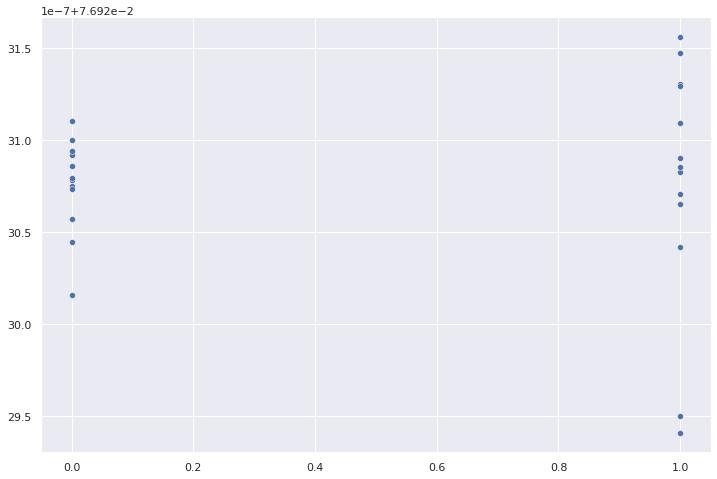

In [130]:
j = 0
k=17
keys = list(all_movies.keys())
scene = all_movies[keys[k]]
scene_scores = []
for i in range(len(scene)):
    iscores = scene[i]['compat_scores'][j]
    ind = [i]*len(iscores)    
    scene_scores.append(list(zip(ind,iscores)))
scene_scores = np.concatenate(scene_scores)    
print(keys[k])
sns.set(rc = {'figure.figsize':(12,8)})
sns.scatterplot(x=scene_scores[:,0],y=scene_scores[:,1])
# sns.boxplot(x=scene_scores[:,0],y=scene_scores[:,1])

In [9]:
def detect_outliers(doc, num_sigma=5.0, num_abs=0.07, use_abs=True):
    n = len(doc['compat_scores'])
    rc = []
    for i in range(n):
        scores = np.array(doc['compat_scores'][i])
        mean = scores.mean()
        var = scores.std()
        if use_abs:
            rc.append(np.where(np.abs(scores-mean)>num_abs)[0])
        else:
            rc.append(np.where(np.abs(scores-mean)>num_sigma*var)[0])

    return rc
    

In [200]:
all_outliers = []
for doc in all_docs:    
    rc = detect_outliers(doc,num_abs=0.05,use_abs=True)
    if len(flatten(rc)) > 0:
        all_outliers.append((doc['movie_id'],doc['scene_element']))

len(all_outliers)

6

In [201]:
all_outliers

[('Movies/222510136', 0),
 ('Movies/222510575', 10),
 ('Movies/222510575', 9),
 ('Movies/222510692', 9),
 ('Movies/222510810', 1),
 ('Movies/222510951', 2)]

In [203]:
mid, elem = all_outliers[0]
doc = all_movies[mid][elem]
# emb_video = clip.clip_encode_video(mid,elem)
list(enumerate(detect_outliers(doc,num_abs=0.05,use_abs=True)))

[(0, array([], dtype=int64)),
 (1, array([], dtype=int64)),
 (2, array([], dtype=int64)),
 (3, array([9])),
 (4, array([9])),
 (5, array([], dtype=int64)),
 (6, array([9])),
 (7, array([8])),
 (8, array([], dtype=int64)),
 (9, array([], dtype=int64))]

In [140]:
i=7
# sim_scores = compute_batch_scores(emb_video,doc['sentences'][i])
# sim_scores = sim_scores - np.mean(sim_scores)
# list(enumerate(zip(doc['sentences'][i],doc['compat_scores'][i], sim_scores)))
list(enumerate(zip(doc['sentences'][i],doc['compat_scores'][i])))

NameError: name 'doc' is not defined

In [135]:
scene = all_movies['Movies/222510575']
# scene = all_movies[mid]
# mid, len(scene), elem
mid, len(scene), 0

('Movies/222509871', 12, 0)

In [142]:
i=0
selem = scene[9]
# list(enumerate(zip(selem['sentences'][i],selem['compat_scores'][i])))
list(zip(selem['sentences'][i],selem['compat_scores'][i]))

[('a group of missiles are flying over a body of water and targeting the beach',
  0.08543837880037813),
 ('a group of missiles are flying over the sea', 0.07731923414998039),
 ('a group of missiles are approaching a beach from a body of green mountains',
  0.07668418111467121),
 ('a group of planes flying over a green mountain towards a beach',
  0.11837373196801622),
 ('a group of planes flying over a body of water and targeting the beach',
  0.12150756873861852),
 ('a group of planes are crossing a green mountain which turns out to be a burning one as they target the beach behind it',
  0.09576741214681339),
 ('a group of missiles are launched over the sea near green mountain',
  0.035417253889548674),
 ('a group of missiles and a trail of smoke are flying over a body of water',
  0.10353808203608124),
 ('a group of missiles flying over a beach', 0.06577014651476489),
 ('a group of planes flying over a green mountain and targeting the beach',
  0.11428733695100425),
 ('a group of pl

In [225]:
s2 = copy.deepcopy(scene[0]['sentences'][i])
s3 = copy.deepcopy(scene[1]['sentences'][i])


In [222]:
# s9[6] = 'a little dark skinned girl with a striped shirt raises her hands up in the air'
# s9[5] = 'A little girl holding hands with others kept her hands raised in the air as they prepared to attack a tribal girl'
s2[8] = 'A large explosion spreads through the cupboard and through the building.'

In [226]:
# rc = story_compatability(scene[9]['sentences'][i], scene[10]['sentences'][i])
rc = story_compatability(s2,s3)

In [227]:
# rc[5].mean()
[x.mean() for x in rc]

[0.9102119717475338,
 0.9998342742522558,
 0.9996089339256287,
 0.9999626278877258,
 0.9999694426854452,
 0.8339914248790592,
 0.999931255976359,
 0.9999830524126688,
 0.3416450340919255,
 0.9991762340068817,
 0.5767992973948518,
 0.9998853007952372]

In [101]:
story = [scene[9]['sentences'][i], scene[10]['sentences'][i]]

In [102]:
rc = score_story(story)

In [103]:
rc

[array([0.09007201, 0.0900718 , 0.09007126, 0.0900725 , 0.09007197,
        0.09003483, 0.00924651, 0.09007168, 0.09007212, 0.09007203,
        0.0900714 , 0.09007186]),
 array([0.09907948, 0.09909141, 0.0990914 , 0.09909344, 0.10803553,
        0.09909128, 0.09919165, 0.09915561, 0.09908441, 0.09908579])]